In [1]:
!pip install basedosdados

In [2]:
import basedosdados as bd
import numpy as np
import pandas as pd

In [3]:
query = "SELECT * FROM datario.adm_central_atendimento_1746.chamado AS c WHERE DATE(c.data_inicio) = '2023-04-01'"
df = bd.read_sql(query, billing_project_id="emd-desafio-jr-data-scientist")

Downloading: 100%|██████████| 1756/1756 [00:00<00:00, 2080.21rows/s]


In [5]:
#quais os nomes dos 3 bairros que mais tiveram chamados abertos nesse dia?

query2 = "SELECT * FROM datario.dados_mestres.bairro AS b"
df2 = bd.read_sql(query2, billing_project_id="emd-desafio-jr-data-scientist")

Downloading: 100%|██████████| 164/164 [00:03<00:00, 49.73rows/s]


In [6]:
#fazer o merge com os valores IS NULL incluídos

chamado_bairro = df.merge(df2, left_on='id_bairro', right_on='id_bairro', how='left')

#3 bairros com mais chamados

chamado_bairro.groupby('nome').size().sort_values(ascending=False).head(3)

,0
nome,
Campo Grande,113
Tijuca,89
Barra da Tijuca,59


In [8]:
#plotando chamado_bairro com plotly

import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import seaborn as sns

chamado_bairro3 = chamado_bairro.groupby('nome').size().sort_values(ascending=False).head(3)

fig = px.bar(chamado_bairro3, x=chamado_bairro3.index, y=chamado_bairro3.values)
fig.update_layout(title='3 bairros com mais chamados', xaxis_title='Bairros', yaxis_title='Quantidade de chamados')
#trocar a cor das barras para darkblue
fig.update_traces(marker_color='darkblue')
fig.show()

In [12]:
#qual tipo mais ocorreu por bairro:

chamado_bairro_tipo = chamado_bairro.groupby(['nome', 'tipo']).size().sort_values(ascending=False)
chamado_bairro_tipo = chamado_bairro_tipo.head(10)
chamado_bairro_tipo


,,0
nome,tipo,
Copacabana,Estacionamento irregular,22
Barra da Tijuca,Estacionamento irregular,21
Campo Grande,Estacionamento irregular,21
Engenho de Dentro,Estacionamento irregular,20
Tijuca,Estacionamento irregular,19
Campo Grande,Remoção Gratuita,19
Bangu,Estacionamento irregular,13
Urca,Estacionamento irregular,13
Campo Grande,Manutenção de iluminação pública,13


In [17]:
#plotando chamado_bairro em seaborn com x = bairro, y = count e com a coluna tipo como legenda dentro das barras
#em plotly

fig = px.bar(chamado_bairro_tipo, x=chamado_bairro_tipo.index.get_level_values(0), y=chamado_bairro_tipo.values, color= chamado_bairro_tipo.index.get_level_values(1), barmode='group')
fig.update_layout(title='Tipo de chamado mais comum por bairro', xaxis_title='Bairro', yaxis_title='Quantidade de chamados')
fig






In [11]:
#qual o nome da subprefeitura com mais chamados abertos nesse dia?

subprefeitura = chamado_bairro.groupby('subprefeitura').size().sort_values(ascending=False)
subprefeitura.head(10)

,0
subprefeitura,
Zona Norte,510
Zona Oeste,238
Zona Sul,233
Grande Tijuca,159
Jacarepaguá,145
Grande Bangu,126
Barra da Tijuca,121
Centro,98
Ilhas,53


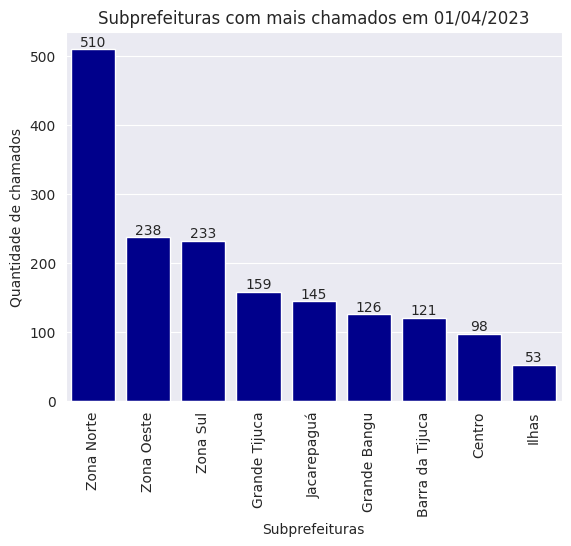

In [18]:
#plotando em seaborn

sns.barplot(x=subprefeitura.index, y=subprefeitura.values)
plt.title('Subprefeituras com mais chamados em 01/04/2023')
plt.xlabel('Subprefeituras')
plt.ylabel('Quantidade de chamados')
#legendas de y dentro das barras
for i, v in enumerate(subprefeitura.values):
    plt.text(i, v, str(v), ha='center', va='bottom')
plt.xticks(rotation=90)
sns.set_style('darkgrid')
#cor das barras em dark blue
for patch in plt.gca().patches:
    patch.set_facecolor('darkblue')
plt.show()

In [19]:
#Existe algum chamado aberto que não foi associado a um bairro ou subprefeitura?

chamado_null = chamado_bairro.groupby('tipo').agg({'id_bairro': lambda x: x.isnull().sum(), 'subprefeitura': lambda x: x.isnull().sum()}).sort_values(by='id_bairro', ascending=False)

# Resposta: Sim, os tipos de chamados não são associados a bairro ou subprefeitura pois se tratam de chamados de atendimento a pessoas e problemas de transporte

In [25]:
#transformar o indice em coluna

chamado_null.reset_index(inplace=True)
chamado_null = chamado_null.head(3)


In [77]:
#plotando em plotly

fig = px.bar(chamado_null, x='tipo', y='subprefeitura')
fig.update_layout(title='Tipos de chamados não associados a um bairro ou subprefeitura', xaxis_title='Tipo de chamado', yaxis_title='Quantidade de chamados')
fig.update_traces(marker_color='darkblue')
fig

In [29]:
#Quantos chamados com o subtipo "Perturbação do sossego" foram abertos desde 01/01/2022 até 31/12/2023 (incluíndo extremidades)

query3 = "SELECT * FROM datario.adm_central_atendimento_1746.chamado AS c WHERE c.subtipo = 'Perturbação do sossego' AND DATE(c.data_inicio) BETWEEN '2022-01-01' AND '2023-12-31'"
df3 = bd.read_sql(query3, billing_project_id="emd-desafio-jr-data-scientist")


Downloading: 100%|██████████| 42830/42830 [00:13<00:00, 3218.48rows/s]


In [30]:
#Selecione os chamados com esse subtipo que foram abertos durante os eventos contidos na tabela de eventos

query4 = "SELECT * FROM datario.adm_central_atendimento_1746.chamado AS c LEFT JOIN datario.turismo_fluxo_visitantes.rede_hoteleira_ocupacao_eventos AS e ON DATE(c.data_inicio) = e.data_inicial WHERE c.subtipo = 'Perturbação do sossego' AND DATE(c.data_inicio) BETWEEN '2022-01-01' AND '2023-12-31' AND e.evento IS NOT NULL"
df4 = bd.read_sql(query4, billing_project_id="emd-desafio-jr-data-scientist")

Downloading: 100%|██████████| 295/295 [00:00<00:00, 1007.09rows/s]


In [32]:
#quantos chamados por evento?

chamados_evento = df4.groupby('evento').size().sort_values(ascending=False)

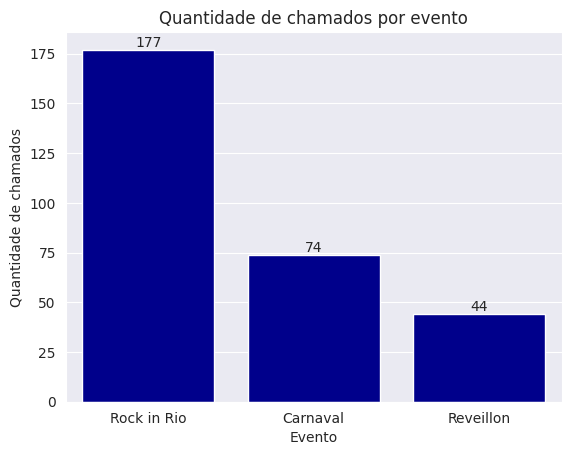

In [36]:
#plotando em seaborn

sns.barplot(x=chamados_evento.index, y=chamados_evento.values)
plt.title('Quantidade de chamados por evento')
plt.xlabel('Evento')
plt.ylabel('Quantidade de chamados')
#barras em darkblue
for patch in plt.gca().patches:
    patch.set_facecolor('darkblue')
#legendas de y nas barras
for i, v in enumerate(chamados_evento.values):
    plt.text(i, v, str(v), ha='center', va='bottom')
sns.set_style('darkgrid')
plt.show()


In [50]:
#qual evento teve a maior média diária de chamados abertos?

# Calcula a duração do evento em dias, garantindo que a duração mínima seja 1 dia
df4['duracao_evento'] = (df4['data_final'] - df4['data_inicial']).dt.days + 1
df4['duracao_evento'] = df4['duracao_evento'].apply(lambda x: max(x, 1))

# Agrupa por evento e calcula o total de chamados e a duração total de cada evento
df_result = df4.groupby('evento').agg({
    'id_chamado': 'count',
    'duracao_evento': 'mean'}).reset_index()

# Calcula a média diária de chamados por evento
df_result['media_diaria_chamados'] = df_result['id_chamado'] / df_result['duracao_evento']
df_result = df_result.sort_values(by='media_diaria_chamados', ascending=False).reset_index(drop=True).round(2)

df_result.head(3)


,evento,id_chamado,duracao_evento,media_diaria_chamados
0,Rock in Rio,177,3.44,51.53
1,Carnaval,74,4.00,18.50
2,Reveillon,44,3.00,14.67


In [55]:
#Compare as médias diárias de chamados abertos desse subtipo durante os eventos específicos e a média diária de chamados abertos desse subtipo considerando todo o período de 01/01/2022 a 31/12/2023

#média de chamados abertos em todo o período em df3:
media_periodo = df3.shape[0] / 730
media_periodo

#arredondar media_periodo para 2 pontos decimais
media_periodo = round(media_periodo, 2)
media_periodo

58.67

Text(0, 0.5, 'Média diária de chamados')

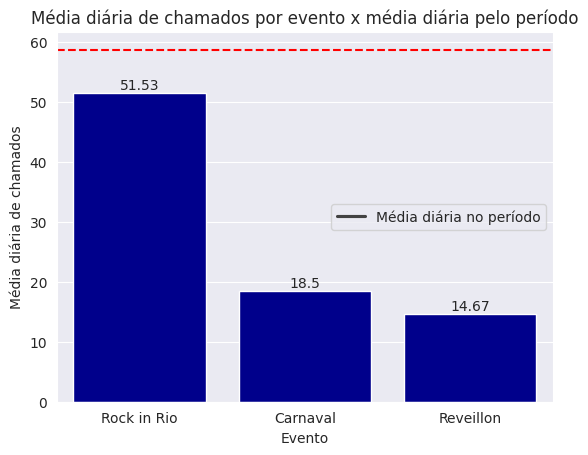

In [66]:
# plotando em seaborn df_result x media_periodo

sns.barplot(x=df_result['evento'], y=df_result['media_diaria_chamados'])
#inserir media_periodo como linha no eixo y
plt.axhline(y=media_periodo, color='r', linestyle='--')
#colocar legenda na linha axhline
plt.legend(['Média diária no período'])
#legendas de y nas barras
for i, v in enumerate(df_result['media_diaria_chamados']):
    plt.text(i, v, str(v), ha='center', va='bottom')

#barras em darkblue
for patch in plt.gca().patches:
    patch.set_facecolor('darkblue')
plt.title('Média diária de chamados por evento x média diária pelo período')
plt.xlabel('Evento')
plt.ylabel('Média diária de chamados')



In [76]:
#plotando o mesmo gráfico em plotly

fig = px.bar(df_result, x='evento', y='media_diaria_chamados')
fig.add_hline(y=media_periodo, line_dash="dash", line_color="red")
fig.update_layout(title='Média diária de chamados por evento x média diária pelo período', xaxis_title='Evento', yaxis_title='Média diária de chamados')
fig.update_traces(marker_color='darkblue')
#colocar o intervalo de y de 0 a 100
fig.update_yaxes(range=[0, 80])
fig.show()
